{[Click aquí para leer este notebook en Google Colab](https://colab.research.google.com/drive/14Jsh9BhvibfCBV3MmTg4yS2GYsE7vCTA)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">4AMBOT | Fase de desarrollo</th>
    <th align = "right">Escrito por: Gaston Solari Loudet</th>
</tr></table>

## <center><b><u>Formulación de estrategia</u></b></center>

La idea de este notebook es de formular la estrategia "**4 AM**" tanto en palabras como en código, de manera de poder tener un modelo de prueba para trabajar, testear, y mas adelante automatizar para su uso en MetaTrader. Si bien la sintaxis de Python es algo mas simplista y contiene muchas herramientas esquemáticas (ej.: dataframes) y matemáticas (ej.: interpolaciones) que no tenemos en MQL, la mayoría de dichas cosas son programables o descargables en internet.

Las bibliotecas de funciones que vamos a necesitar, son las siguientes:
<ul><li>"<code>datetime</code>": Datos fecha/hora y manejo del tiempo.
</li><li>"<code>pandas</code>" y "<code>numpy</code>": Visualización de datos tabulados y herramientas matemáticas varias.
</li><li>"<code>matplotlib</code>": Gráficos. De todos modos usaremos 2 objetos específicamente programados para esto: "<code>GMAData</code>" y "<code>GMAPlot</code>".<br>Se descargan con "<code>requests</code>" desde GitHub. No se lo puede hacer desde Google Drive por sus actuales bloqueos de seguridad.</li></ul>

In [1]:
import sys, pandas, numpy, datetime, matplotlib, matplotlib.pyplot, requests
Git, File = "https://raw.githubusercontent.com/gsolaril/4AMBOT/main/", "tools.py"
#REQ = requests.get(Git + File, allow_redirects = True)
#open("./tools.py", "wb").write(REQ.content)
GDrive = "https://drive.google.com/uc?id="
ID = "1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ"
matplotlib.pyplot.style.use(GDrive + ID) ## Plot template.
from IPython.display import display
from datetime import datetime as dT
from tools import GMAData, GMAPlot

### <center><u><b>Clase "<code>LineStack</code>"</b></u></center>

In [ ]:
class LineStack(object):
    __Default = {"mstep": 0.001, "msize": 8, "color": "purple"}
    def __init__(self, mstep: float = None, msize: int = None, color: str = None):
        self.__mstep = LineStack.__Default["mstep"] if (mstep == None) else mstep
        self.__msize = LineStack.__Default["msize"] if (msize == None) else msize
        self.__color = LineStack.__Default["color"] if (color == None) else color
        self.__stack = pandas.DataFrame(columns = ["dtime", "score"])
    def __repr__(self):
        display(self.__stack)
        return "\nLimits => " + str(self.limits())
    def values(self): return self.__stack.copy()
    def length(self): return len(self.__stack)
    def limits(self): return {"step": self.__mstep, "size": self.__msize}

In [ ]:
class LineStack(LineStack):
    def __init__(self, mstep: float = None, msize: int = None, color: str = None):
        super().__init__(mstep = mstep, msize = msize, color = color)
    def append(self, value: float, dtime: dT, score: float = None):
        value = round(value / self.__mstep) * self.__mstep
        self.__stack.loc[value, :] = [dtime, score]
        self.__stack.sort_index(inplace = True)
        if (self.length() <= self.__msize): return
        t_old = self.__stack["dtime"].min()
        i_old = (self.__stack["dtime"] == i_old)
        p_old = self.__stack.index[i_old]
        self.__stack.drop(p_old, inplace = True)
    def bind(self, value: float):
        L = self.length()
        bound = numpy.array([0, numpy.inf])
        if (L == 0): return bound
        x = (self.__stack.index < value).sum()
        if (0 < x): bound[0] = self.__stack.index[x - 1]
        if (x < L): bound[1] = self.__stack.index[x - 0]
        return bound

In [ ]:
p_start, p_delta, N = 1.234, 1e-3, 24000
########################################
start = dT(2025, 10, 1)
index = numpy.random.randint(0, N, 15)
rdata = numpy.random.randn(N).cumsum()
Stack = LineStack(mstep = p_delta*10)
dt = datetime.timedelta(minutes = 10)
rdata = p_start + rdata*p_delta
for i in numpy.sort(index):
    p, t = rdata[i], start + dt*i
    Stack.append(value = p, dtime = t)
print("\nStack data:") ; print(Stack, "\n") 
p = rdata[index].mean() ; pb = Stack.bind(p)
print("Bounds for \"%.4f\": %s" % (p, pb))


Stack data:


,dtime,score
1.20,2025-11-07 03:50:00,None
1.21,2026-02-27 10:30:00,None
1.22,2026-02-21 02:30:00,None
1.23,2026-02-24 03:30:00,None
1.24,2026-01-21 14:50:00,None
1.25,2026-03-10 20:20:00,None
1.28,2025-12-29 21:50:00,None



Limits => {'step': 0.01, 'size': 8} 

Bounds for "1.2313": [1.23 1.24]


### <center><u><b>Búsqueda de reversals</b></u></center>

Como se ha visto y describiremos en detalles mas adelante, el método se basa fuertemente en un movimiento contratendencial que se da casualmente durante la vela de las 4 AM (UTC -3). Se lo puede observar como un rebote, un pullback o una simple mecha de rechazo. Como sea, nos interesa tener una herramienta para detectar este tipo de reacciones. 

En principio, debería ser una herramienta con un enfoque 100% geométrico. Es decir: debería funcionar para una secuencia continua de puntos cualesquiera, que no necesariamente sean de mercado. Por ello, nos centraremos en programarla y probarla para datos generados de forma aleatoria. Debería funcionar exactamente igual que con datos de mercado.

#### <u><b>Generador de datos aleatorios</b></u>

La forma mas facil de hacerlo, es simulando una "[Random Walk](https://en.wikipedia.org/wiki/Random_walk)". Es decir: que para un punto "$t$" de valor "$p(t)$", el punto que le sigue "$t + 1$" tenga un valor "$p(t + 1) = p(t) + \Delta p \times R$" adonde aquella "$R$" es un salto aleatorio de distribución de probabilidad normal, con media 0 y distribución estandar 1. En tal caso, aquel "\Delta p" es "cuanto queremos que ambos precios sucesivos difieran comúnmente uno de otro": lo que en general llamamos "<u>volatilidad</u>". ("``p_delta``")

Con "``numpy.random.randn``" generamos una sucesión de valores "$R$" aleatorios. Luego, calculamos su suma cumulativa ("``cumsum``") ya que lo que genera una Random Walk es la suma progresiva de dichos saltos: "$p(t) = p(0) + \Delta p \;\Sigma R_i$". Aquel "$p(0)$" es el valor del cual partimos. ("``p_start``")

Vamos a establecer algunas pautas:
* Con esos puntos vamos a armar velas japonesas. Vamos a usar 10 puntos para cada una.
* Con esas velas, vamos a armar "grupos" de velas adonde vamos a aplicar esa herramienta. Cada grupo va a contener "$n_V$" velas.
* Vamos a tener una cantidad total de "$n_G$" grupos, para poder comparar entre varios patrones de reversión, uno al lado del otro.

En el gráfico, el eje horizontal enumera a las velas de la forma "**01, XX:YY**" adonde "**XX**" es el número de grupo, mientras que "**YY**" es el número de vela dentro del grupo. Las lineas verticales separan a cada grupo. Observar como al aumentar la volatilidad "``p_delta``", si bien las velas no crecen visualmente de tamaño, los valores del eje vertical si lo hacen. Esto tendrá importancia a futuro.

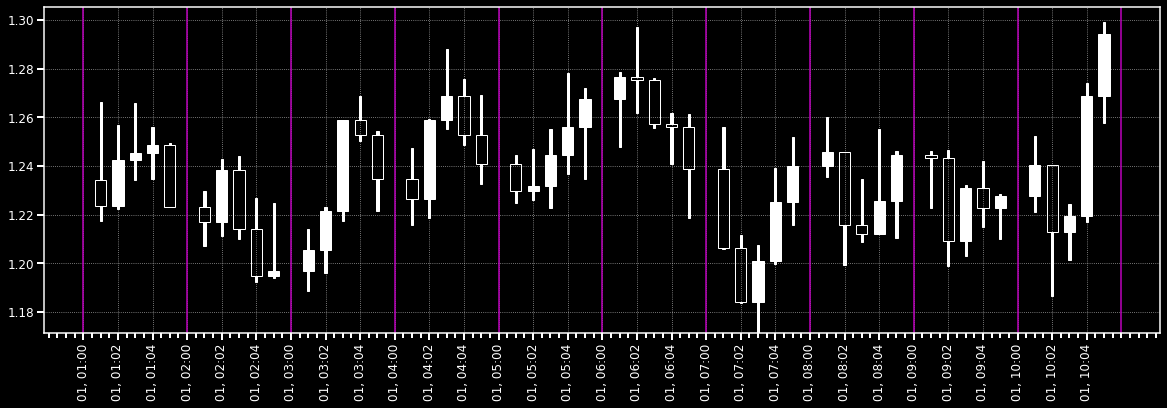

In [ ]:
T = start  ;   nV = 5  ;   nG = 10
##################################
h = datetime.timedelta(hours = 1)
m = datetime.timedelta(minutes = 1)
T = T + h*(numpy.arange(nG + 1)[:, None])
T = T + m*(numpy.arange(nV + 1)[None, :])
T = T.reshape(1, -1).squeeze()[nV + 1:]
nn = numpy.array([numpy.nan]*nG)[:, None]
rdata = rdata.round(5).reshape(nG, nV, -1)
O, c = rdata[:, :, 0], rdata[-1, -1, -1]
H, L = rdata.max(2), rdata.min(2)
C = O.reshape(1, -1)[0, 1:]
C = numpy.append(C, c).reshape(nG, -1)
O = numpy.hstack((nn, O)).reshape(1, -1).squeeze()
H = numpy.hstack((nn, H)).reshape(1, -1).squeeze()
L = numpy.hstack((nn, L)).reshape(1, -1).squeeze()
C = numpy.hstack((nn, C)).reshape(1, -1).squeeze()
rdata1 = dict(zip(list("OHLC"), [O, H, L, C]))
rdata1 = pandas.DataFrame(rdata1, index = T)
_f1, _a1 = GMAPlot.candle_plot(rdata1)
_a1.tick_params(labelsize = 12)
for n in range(nG + 1):
    _a1.axvline(x = (nV + 1)*n, color = "m")

#### <u><b>Función de intensidad de rebote</b></u>

El objetivo fundamental es el de encontrar cierta función matemática que tome a los "$n_V$" valores de las velas, y devuelva un número que dé una idea de "la intensidad del rebote". Que sea...
* ...positivo cuando la reacción es de abajo hacia arriba.
* ...negativo cuando la reacción es de arriba hacia abajo.
* ...casi cero cuando se mantiene una tendencia.
* ...casi cero cuando el mercado se mueve de manera horizontal.

Durante estas últimas semanas, se investigaron varias variantes. La mayoría tienen que ver con la relación de tamaño entre mechas de velas y cuerpos. A continuación, algunos borradores:

<center><img src = "https://drive.google.com/uc?id=12U2i9Q73UIRDLQzJrtXLb6JMRn38DO2_" width = "75%%"></img></center>

Una opción tentativa es la de usar regresiones a través de cada bloque. Como las reversiones no son geometrías lineales ya que necesitamos una derivada segunda, como mínimo tenemos que usar una aproximación cuadrática y sus respectivas derivadas:
* "$f(t) = a_0 + a_1 t + a_2 t^2$".
* "$f'(t) = a_1 + 2 a_2 t$".
* "$f''(t) = 2 a_2$".

Justamente, a la derivada segunda "$f''(t)$" a veces se la suele llamar "curvatura" ("$K$"). Cuanto mas chica es, mas "recta" es la curva. Al mismo tiempo: la curva dibuja una $\cup$ si "$K$" es positiva, o una $\cap$ en caso contrario.

#### <u><b>Regresiones</b></u>

A la hora de hacer una regresión, no nos sirve tener "velas". Necesitamos puntos: debemos elegir cuales "<u>puntos característicos</u>" tomar de las velas. Podríamos usar los valores de cierre ("``Close``") pero aquellos no contemplan los extremos a los cuales llegaron los precios, y aquello es precisamente lo que necesitamos. Por lo tanto lo que hacemos es tomar el <u>promedio</u> de los "``High``" y los "``Low``". Recordar que nuestros datos "``ohlc``" son un ``dataframe`` con lo cual podemos asignarles un vector de pesos ("``[O, H, L, C] = [0, 1/2, 0, 1/2]``") mediante un producto escalar ("``dot``") por cada vela.

La función "``numpy.polyfit``" me devuelve un vector ("``poly``") con los coeficientes del polinomio regresor: "$(a_0, a_1, a_2,..., a_n)$". De manera facil, se pueden obtener los vectores de las derivadas ("``d1_x``" y "``d2_x``") con la función "``numpy.polyder``". Hay que evaluar el valor ("``d1_v``" y "``d2_v``") de cada uno de estos polinómios en la sucesión de puntos característicos (promedios High-Low). Una vez hecho esto, podemos incluso ya dibujar las curvas aproximadoras sobre los grupos de velas.

In [ ]:
class LineStack(LineStack):
    def __init__(self, mstep: float = None, msize: int = None, color: str = None):
        super().__init__(mstep = mstep, msize = msize, color = color)
    @staticmethod
    def polytest(nodes: list, deg: int = 2):
        t = numpy.arange(len(nodes))
        poly = numpy.polyfit(t, nodes, deg)
        d1_x = numpy.polyder(poly, m = 1)
        d2_x = numpy.polyder(poly, m = 2)
        d1_v = numpy.polyval(d1_x, t)
        d2_v = numpy.polyval(d2_x, t)
        x_d0 = numpy.abs(d1_v).argmin()
        return poly, x_d0, d2_v[x_d0]



<u>Como nos damos cuenta de si existe una reversión</u>? La condición mas importante es que si hay un máximo/mínimo en el polinomio, que este se ubique **dentro** de la curva. Eso quiere decir: en las velas centrales y no en las que estan en los límites de cada grupo. No podemos tomar un grupo de velas de tamaño "$n_V$" infinito: sino, el análisis sería demasiado impreciso (nos estaríamos alejando demasiado de las 4 AM). Al limitarnos a un "$n_V$" menor, inevitablemente estamos dejando velas afuera hacia ambos lados del grupo.

<center><img src = "https://drive.google.com/uc?id=1CUjWzAPpVZwe7Mmx1wayGUXVHRj9EbW8" width = "35%"></img></center>

Pero por ejemplo: Supongamos que, como indica la figura de arriba, hallamos un mínimo en la primera **\[**o última**\]** vela del grupo. Si no tenemos en cuenta aquello que pasa en las velas de mas allá a la izquierda **\[**o derecha**\]** ¿Como podemos saber que es un mínimo de verdad? En ese caso, es mejor descartarlos y suponer que no lo son. Al centrarnos en los máximos y mínimos observables en el centro de un grupo ("$0 < t < n_V - 1$"), ubicar reversiones es mas facil y mas seguro. En términos matemáticos, los máximos/mínimos son aquellos puntos adonde la derivada primera ("``d1_v``") es cero. O en este caso, adonde el valor absoluto ("``abs``") es el menor posible ("``numpy.argmin``").

Las curvas rojas en la figura siguiente, son las curvas interpoladoras de los polinomios. Aquellos máximos/mínimos que fueron validados como reversiones, se ven como trazos amarillos. Debajo de cada patrón de reversión, se ve el valor de la curvatura "$K$" (derivada segunda). 

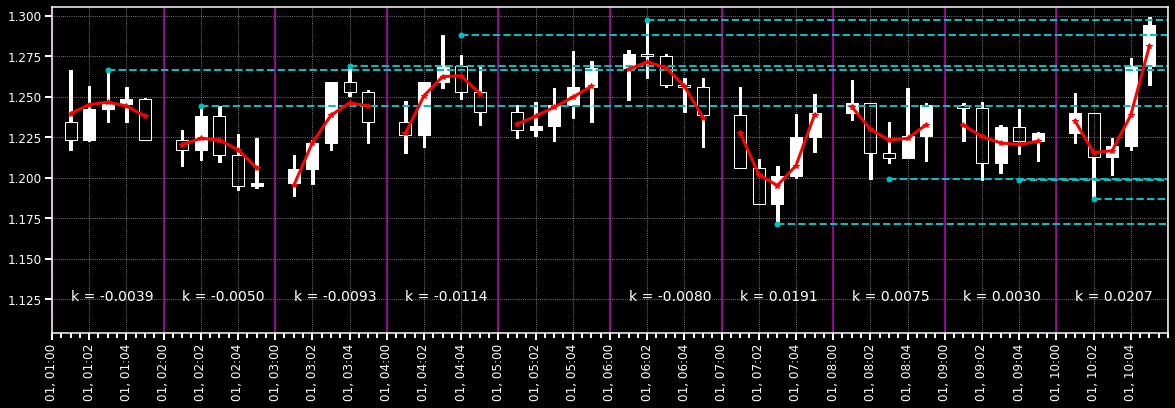

In [ ]:
ymin, ymax = _a1.get_ylim()
dy = (ymax - ymin)*3/2
ymin = ymax - dy
for n in range(1, len(rdata1), nV + 1):
    t = numpy.arange(nV) + n
    block = rdata1.iloc[t, :]
    nodes = block.dot([0, 1/2, 1/2, 0])
    p, x, k = LineStack.polytest(nodes, 2)
    _a1.plot(t, numpy.polyval(p, t - n), "-*r", lw = 3)
    if not (0 < x < nV - 1): continue
    if (k > 0): y = block["L"].min()
    if (k < 0): y = block["H"].max()
    yt = [y, y]  ;  xt = [n + x, len(rdata1)*2]
    _a1.plot(xt, yt, "--oc", ms = 5, lw = 2)
    yt = ymin + dy/10  ;  st = "k = %.4f" % k
    _a1.text(x = n, y = yt, s = st, fontsize = 14)
_a1.set_xlim(0, len(rdata1))
_a1.set_ylim(ymin, ymax);  _f1

¿<u>Podemos usar "$K$" como nuestro número de intensidad de rebote</u>? En realidad, no del todo. Si bien cumple con las condiciones enlistadas mas arriba, dicho número no contempla el tema de la volatilidad. Podemos tener un "$K$" muy alto, y aun así no ser muy significativo por estar en un periodo de consolidación muy volatil. O en caso contrario, podemos tener un "$K$" bajo y significar una reversión ante una tendencia leve pero sostenida. Si bien no es necesario para continuar, sería bueno mejorar este algoritmo agregando algún factor de normalización que incluya a la volatilidad como variable.

Otro tema: ¿<u>Debería usarse un grado de polinomio mas alto que 2</u>? Hay que tener cuidado con esto. Por teorema fundamental del álgebra, no se puede interpolar una secuencia de "$n_V$" puntos con un grado mayor a "$n_V$". El usar un grado mas alto, hace que el polinomio sea mas preciso. Pero lo bueno de usar "``deg = 2``" es que aseguramos que solo se contemple un único máximo/mínimo en todo el grupo. De otro modo, corremos el riesgo de tener una curva aproximadora con forma de "N" o "M" en lugar de la "U" que buscamos.

#### <b><u>Función "`RevScan`"</u></b>

In [ ]:
class LineStack(LineStack):
    def __init__(self, mstep: float = None, msize: int = None, color: str = None):
        super().__init__(mstep = mstep, msize = msize, color = color)
    @staticmethod
    def RevScan(block: pandas.DataFrame, k_min: float = 5e-3, deg: int = 2):
        weights = [0]*block.shape[1]
        weights[:4] = [0, 1/2, 1/2, 0] # O, H, L, C
        index, nodes = block.index, block.dot(weights)
        _, x, k = LineStack.polytest(nodes, deg)
        if not (0 < x < len(index) - 1): return dict()
        if not (abs(k) >= k_min): return dict()
        if (k >= +k_min): y = block["L"].min()
        if (k <= -k_min): y = block["H"].max()
        return { "dtime": index[x], "value": y, "curv": k }

In [ ]:
rdata2 = rdata1.dropna(); k_min = 5e-3
Stack = LineStack(mstep = p_delta*10)
for n in range(0, len(rdata2), nV):
    block = rdata2.iloc[n : n + nV, :]
    scan = LineStack.RevScan(block, k_min)
    if not scan: continue
    scan["score"] = abs(scan["curv"])/k_min
    scan["score"] = scan["score"].round(3) - 1
    scan.pop("curv")  ;  Stack.append(**scan)
Stack.values()

,dtime,score
1.17,2025-10-01 07:03:00,2.815
1.19,2025-10-01 10:02:00,3.147
1.20,2025-10-01 08:03:00,0.497
1.24,2025-10-01 02:02:00,0.008
1.27,2025-10-01 03:04:00,0.869
1.29,2025-10-01 04:04:00,1.277
1.30,2025-10-01 06:02:00,0.598


### <center><b><u>Descarga de datos de mercado</u></b></center>

Comúnmente, hemos usado siempre a [Yahoo Finance](https://github.com/ranaroussi/yfinance) y archivos CSV como fuentes de historial de mercado. Sin embargo, necesitamos algo que:
* Tenga un horizonte de datos de mas de un mes.
* No tenga periodos de cierre de mercado (excepto fines de semana)
* No tenga limitaciones de descarga (request) demasiado estrechas.
* Tenga datos de un broker del cual se conozca su zona horaria (ej.: [OANDA](https://www.oanda.com/bvi-es/), UTC 0).

#### <b><u>Descarga de datos mediante [Finnhub.io](https://finnhub.io/docs/api/forex-candles)</u></b>

Los datos descargados de Finnhub vienen con marcas temporales en formato Unix.
<br>Se suma la diferencia horaria en segundos ("$d_{UTC} \;[hs] \times 60 \;min/h \times 60 \;seg/min$").
<br>El eje horizontal de la gráfica, muestra las marcas temporales como "DD, HH:MM".

In [ ]:
import finnhub
FCL = finnhub.Client(api_key = "c1cjh0748v6vbcpf2rlg")
#####################################################
def download_fh(symbol, frame = 60, days = 120):
    d_UTC = -3  # Se banca hasta 2000 velas.
    t = datetime.datetime.now()
    t = int(t.timestamp())
    t0 = t - days*24*60*60
    Data = FCL.forex_candles(symbol, frame, t0, t)
    Data.pop("s")    ;    Data = pandas.DataFrame(Data)
    Data["t"] = Data["t"] + d_UTC*60*60
    Data.set_index("t", inplace = True)
    Data.index = pandas.to_datetime(Data.index, unit = "s")
    Data.columns = [_.upper() for _ in Data.columns]
    return Data

#### <b><u>Descarga de datos mediante [IQ Option](https://iqoptionapi.github.io/iqoptionapi/en/)</u></b>

In [ ]:
from iqoptionapi.stable_api import IQ_Option as iq
API = iq("gsolaril@alu.itba.edu.ar", "12345678")  ;  API.connect()
########################################################################
def download_iq(symbol: str, frame: int, rows: int, now: dT = None):
    if (now == None): now = dT.now()
    Data = pandas.DataFrame()
    t = int(now.timestamp())
    while (rows):
        n_rows = min(1000, rows)
        data = API.get_candles(symbol, frame, n_rows, t)
        data = pandas.DataFrame(data).rename(columns = {"volume": "V",
            "from": "t", "open": "O", "max": "H", "min": "L", "close": "C"})
        data.set_index(keys = "t", drop = True, inplace = True)
        data.index = pandas.to_datetime(data.index, unit = "s", utc = True)
        data.index = data.index.tz_convert("America/Argentina/Buenos_Aires")
        data.drop(columns = ["id", "at", "to"], inplace = True)
        data = data.iloc[:, [0, 3, 2, 1, 4]]
        Data = pandas.concat((data, Data))
        rows, t = rows - n_rows, t - n_rows*frame
    return Data.sort_index().drop_duplicates()

### <center><b><u>Búsqueda de lineas de soporte y resistencia</u></b></center>

Las lineas de soporte y resistencia (S&R) son parte de las varias teorías "polémicas" que contemplan al mercado como un sistema parcialmente determinista. Se creen que los fenómenos que la causan, son certeros y predecibles: no aleatorios. Por eso, como se oponen a la "[hipótesis del mercado eficiente](https://en.wikipedia.org/wiki/Efficient-market_hypothesis)", estaría mal usar datos generados de manera aleatoria. Necesitamos datos reales de mercado para suponer su existencia.

#### <b><u>Uso de canales de máximos/mínimos móviles</u></b>

Si bien nuestro uso de las lineas S&R dentro de esta estrategia será similar al de los reversals, contemplamos a su origen y naturaleza como algo diferente. En el caso de los reversals, buscamos areas de reacción en momentos puntuales del día que nosotros definimos (mas especificamente, cerca de las AM). En el caso de las lineas S&R, no nos importa el momento del día en el cual son tocadas, sino la cantidad de veces que sucede. Es la incidencia de ellas en todo momento del día, lo que nos importa.

No conviene usar regresiones polinómicas como en el caso anterior, porque tendríamos que tomar demasiados grupos de velas. Y en esos grupos de velas, el tamaño debería ser variado para filtrar que las lineas mas importantes prevalezcan sobre las menos incidentes. De modo que lo que haremos entonces, será mas simple: buscar máximos y mínimos a través de toda una amplia gama de velas pasadas, quedandonos con aquellos valores que se concentran en un area densa.

Así como comúnmente usamos médias móviles ("``rolling``") en trading, existen también los ``máx``imos/``mín``imos móviles; que toman una ventana de velas de un cierto ``period``o, y se quedan con el "High" ("``H``") mas alto y el "Low" ("``L``") mas bajo. Normalmente se los conoce como "canales de [Donchian](https://en.wikipedia.org/wiki/Donchian_channel)". Para mejor visualización, graficamos solo las últimas 100-200 velas con sus respectivos canales en azul. 

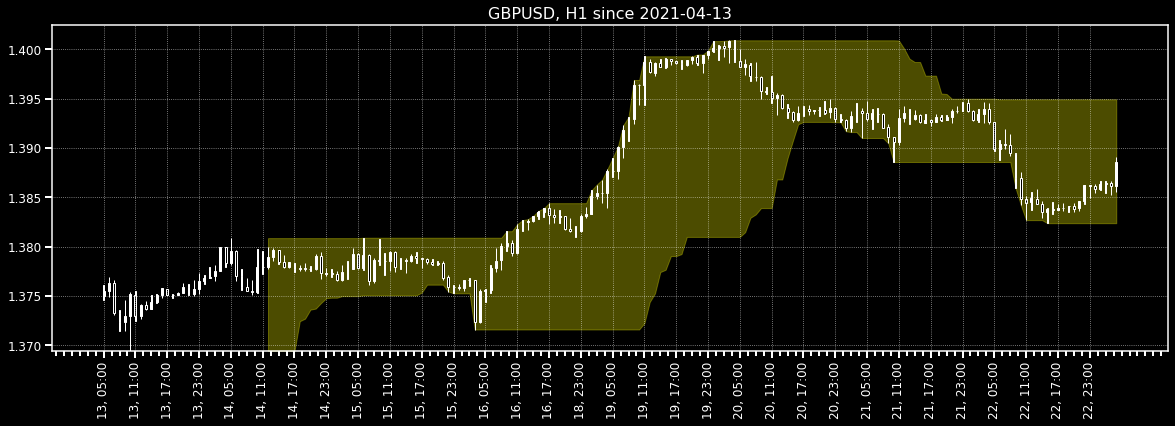

In [ ]:
period = 32  ;  candles = 192  
frame = 3600 ;  sym = "GBPUSD"
#################################
Data1 = download_iq(symbol = sym, frame = frame, rows = candles)
Data1.loc[:, "Don.max"] = Data1.loc[:, "H"].rolling(period).max()
Data1.loc[:, "Don.min"] = Data1.loc[:, "L"].rolling(period).min()
tf = f"H{frame//3600}" if (frame >= 3600) else f"M{frame//60}"
t0 = Data1.index[0].strftime("%Y-%m-%d")
_f2, _a2 = GMAPlot.candle_plot(Data1)
_a2.set_title(label = f"{sym}, {tf} since {t0}", fontsize = 16)
_a2.fill_between(range(len(Data1)), Data1.loc[:, "Don.max"],
    Data1.loc[:, "Don.min"], color = "yellow", alpha = 0.3);

#### <b><u>Lineas S&R como valores recurrentes</u></b>

Conceptualmente, es como si los canales Donchian dibujasen segmentos de S&R a corto plazo en la gráfica. Pero "uniendo" segmentos a una altura similar, podríamos obtener una linea de S&R. Es decir: si en la gráfica aquí arriba ubico una "regla" sobre la pantalla a lo largo de un techo o piso azul, y veo que hay otra linea de ellas que coincide, puedo resaltada como una linea. Si el segmento es mas largo, o si hay varios segmentos alrededor de una misma altura, entonces esa linea debería ser mas "resaltada".

Ese es el criterio que utilizaremos. Análogo a ello, es igual que contar la cantidad de veces que cada valor de los canales Donchian aparecen dentro del dataframe descargado desde Finnhub. Pero para tener en cuenta la incidencia de cada linea en areas tanto locales como globales, necesitamos una gama extensa de ``period``os de Donchian.

Tener en cuenta que con los canales Donchian, tenemos el mismo inconveniente inicial que con cualquier indicador móvil ("``rolling``") de análisis técnico: para un periodo "$P$", recién voy a tener el primer cálculo válido de indicador pasadas las primeras "$P$" velas. Previo a eso, tendré solo valores indeterminados ("``NaN``"). Si quiero tener la mayor cantidad de valores de Donchian precisos para un dataframe con "$N$" velas, el periodo mas grande que voy a poder usar, evitando quedarme sin datos, será de "$N/2$" ([criterio de Nyquist](https://en.wikipedia.org/wiki/Nyquist_rate)).

La evidencia de esto está en que al ver la siguiente grilla de valores de Donchian vs. tiempo y periodo, los NaN empiezan a desaparecer hacia la mitad, yendo desde arriba hacia abajo.

In [ ]:
class LineStack(LineStack):
    def __init__(self, mstep: float = None, msize: int = None, color: str = None):
        super().__init__(mstep = mstep, msize = msize, color = color)
    @staticmethod
    def meshtest(data: pandas.DataFrame, p_range: range):
        Mesh = pandas.DataFrame()
        for p in p_range:
            if (p < 2) or (p > len(data)): continue
            Mesh[f"max_{p}"] = data["H"].rolling(p).max()
            Mesh[f"min_{p}"] = data["L"].rolling(p).min()
        return Mesh.dropna().values.reshape(1, -1).squeeze()

Como ya vimos, a mas cantidad de velas ($N$), **(1)** mas valores de Donchian ($N/2$), pero **(2)** mas periodos también ($N/2$) si es que tomamos todos los posibles. Por ello, se puede decir que el algoritmo tiene <u>complejidad cuadrática</u>: "$O(N^2/4)$". Precisamente, "$N^2/4$" es el area del triangulo ocupado por números no-NaN en la grilla de arriba: de altura "$N$" y ancho "$N/2$" (periodos).

Despues de eliminar todas las filas con "``NaN``s" ("``dropna``"), Comenzamos un conteo (``value_counts``) de la cantidad de veces que cada mismo número aparece. Vamos así, armando una lista de valores recurrentes. Los que mas veces aparecen, son las lineas S&R mas fuertes. Pero notar que dado que a la grilla la debemos re-transitar en sus "N^2/4" valores para este conteo, la complejidad del algoritmo se duplica: "$O(N^2/2)$"

Esto puede ser peligroso ya que puede tomar demasiado tiempo/memoria en un sistema de trading automático. Pero afortunadamente, la estrategia es intradía, con 24 hs entre trade y trade según convenido. Y tampoco es que tenemos que estar buscando lineas de S&R todo el día, todo el tiempo. Podemos hacer un análisis exhaustivo (1000 velas en H1) una vez al día, y otro mas reciente (48 velas) cerca de las 4 AM. Como es cuestión de contar incidencias, ambos análisis son independientes y mutuamente complementarios. Se deja para un futuro, buscar la manera de reducir la complejidad computacional de este método.

Agregamos un número de filtro "$pc_{min}$": Si la linea mas importante aparece en "$f_{max}$" ocasiones, toda aquella linea que aparezca menos de "$pc_{min} \times f_{max}$" veces, se descarta. Por ejemplo: Si la linea mas fuerte apareció 1000 veces y usamos un filtro del 10%, pondremos en la lista a todas las lineas que aparecen mas de 100 veces.

In [ ]:
pc_min = 0.1
############
p_range = range(2, len(Data1)//2, 2)
Mesh = LineStack.meshtest(Data1, p_range)
Count = pandas.value_counts(Mesh.round(5)).to_frame()
columns = {"index": "Lines", 0: "Count"}
Count = Count.rename(columns = columns).reset_index()
fmax = Count.loc[:, "Count"].max()
Count = Count[Count.iloc[:, -1] > fmax*pc_min]
Count.index += 1   ;   Count.transpose()

,1,2,3,4,5,6,7,8
index,1.40091,1.37161,1.38238,1.38858,1.38099,1.39929,1.39493,1.39499
Count,2146.00000,1284.00000,604.00000,598.00000,470.00000,454.00000,377.00000,247.00000


#### <b><u>Futuras mejoras</u></b>

A continuación simplemente graficaremos la lista filtrada de lineas resultantes. El grosor del trazo es proporcional a la incidencia: Aquella que mas veces aparece, será mas gruesa.

El método elegido es simple y conciso. Se basa en conceptos 100% básicos y lógicos. De todos modos, se basa en "fuerza bruta", lo cual puede hacerlo algo impreciso e ineficiente. Una cuestión pendiente de atacar, es en el hecho de que las lineas S&R no son lineas sino areas: no son un precio único, sino un rango estrecho.

Se debe buscar la forma de "unificar" aquellas lineas muy cercanas unas de otras, para evitar tener una lista demasiado grande y sin sentido. Mas adelante se verá que por lo general, estas lineas son usadas como "inhibidoras" de trades: se supone que demasiada cercanía a ellas puede disminuir la probabilidad de reversión a las 4 AM. El exceso de lineas puede inhabilitar al sistema de ejecutar trades en areas adonde sí podría hacerlo. Es no mas que simplemente mejorar el método de filtrado.

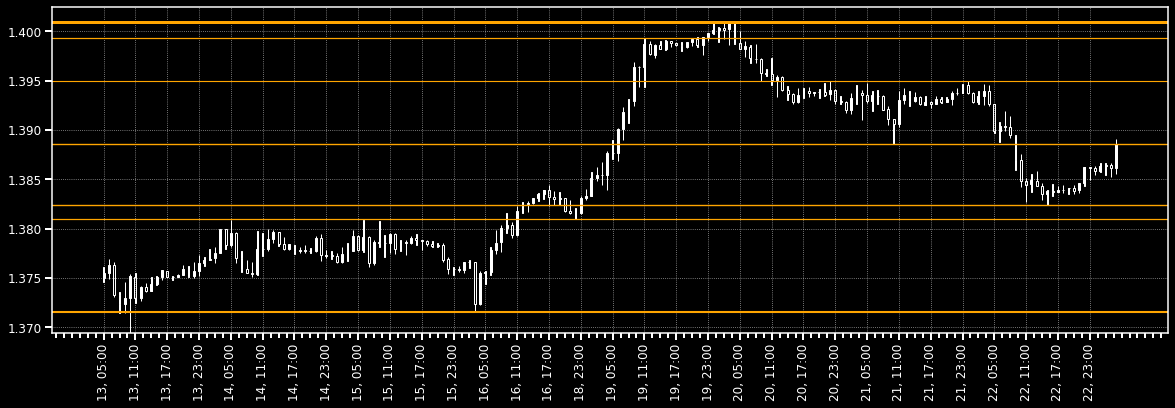

In [ ]:
_f3, _a3 = GMAPlot.candle_plot(Data1)
## "w": Grosor de trazo mínimo y máximo.
fmin, wmin, wmax = Count["Count"].min(), 1, 3
## FUnción grosor proporcional a que tan frecuente es el valor:
width = lambda x: wmin + (wmax - wmin)*(x - fmin)/(fmax - fmin)
for n in range(len(Count)):
    line, freq = Count.iloc[n, :]
    _a3.axhline(y = line, lw = width(freq), color = "orange")

### <center><b><u>Condensado de lineas cercanas</u></b></center>

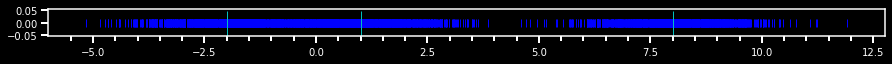

In [ ]:
ref = numpy.array([-2, 1, 8])
np = 1000   ;   std = 1
pts = numpy.array([])
for mean in numpy.sort(ref):
    pts_i = numpy.random.randn(np)*std
    pts_i = mean + numpy.sort(pts_i)
    pts = numpy.hstack([pts, pts_i])
def stretchplot(pts, ref = None, res = None):
    _f, _a = matplotlib.pyplot.subplots()
    _a.plot(pts, 0*pts, "|b", ms = 8)
    if not isinstance(ref, type(None)):
        _a.plot(ref, 0*ref, "|c", ms = 25)
    if not isinstance(res, type(None)):
        _a.plot(res, 0*res, "dc", ms = 6)
    _f.set_figheight(0.5); _a.grid(False)
    return _f, _a
stretchplot(pts = pts, ref = ref);

#### <b><u>K-Means clustering</u></b>

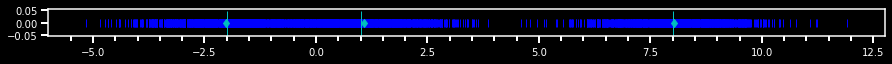

In [ ]:
class clustering1D:
    @staticmethod
    def kMeans(pts: numpy.ndarray, K: int, tol: float):
        pts.sort()  ;  p1, p2 = pts[[0, -1]]
        nodes = numpy.linspace(p1, p2, 2*K + 1)
        nodes = nodes[1 :: 2] ; converged = False
        while not converged:
            nodes_old = nodes.copy()
            delta = pts[:, None] - nodes[None, :]
            delta = numpy.abs(delta)
            index = numpy.argmin(delta, axis = 1)
            for node in range(K):
                nears = pts[index == node]
                nodes[node] = nears.mean()
            dist = nodes - nodes_old
            dist = numpy.abs(dist).max()
            converged = (dist < tol)
        return nodes, (delta**2).sum()
K, tol = len(ref), 0.0001
res, _ = clustering1D.kMeans(pts, K, tol)
stretchplot(pts = pts, ref = ref, res = res);

#### <b><u>Estimación de funciones de kernel</u></b>

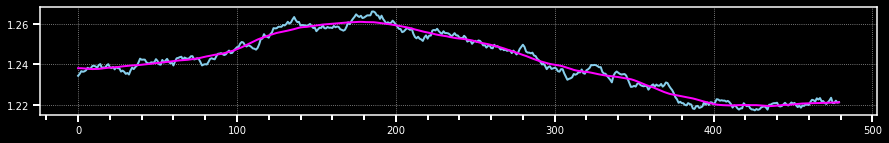

In [ ]:
class clustering1D(clustering1D):
    @staticmethod
    def lSmooth(values, smooth = 50):
        L, w = len(values), smooth//2
        result = list()
        for i in range(L):
            a, b = max(i - w, 0), min(i + w, L)
            window = numpy.arange(a, b)
            result.append(values[window].mean())
        return numpy.array(result)

Y1 = rdata[0, 0, :]  ;  Y2 = clustering1D.lSmooth(Y1) 
_f42, _a42 = matplotlib.pyplot.subplots(figsize = (15, 2))
_a42.plot(range(len(Y1)), Y1, color = "skyblue", lw = 2)
_a42.plot(range(len(Y2)), Y2, color = "fuchsia", lw = 2);

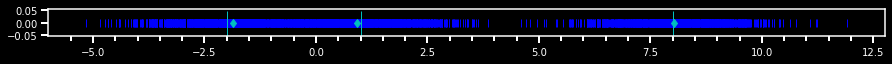

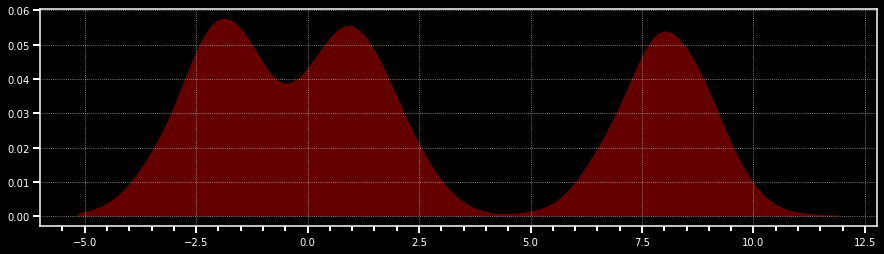

In [ ]:
from scipy.signal import argrelextrema
from scipy.stats import norm
class clustering1D(clustering1D):
    @staticmethod
    def gKernel(pts, smooth = None):
        pts.sort() ; L = len(pts)
        bw = pts.std()/(L**(1/5))
        p1, p2 = pts[0], pts[-1]
        if smooth == None: smooth = int(L**(2/5))
        X = numpy.linspace(p1, p2, len(pts))
        Y = numpy.zeros(X.shape)
        min_diff = X[1] - X[0]
        comp = numpy.greater
        converged = False
        while not converged:
            bw = bw/2
            nodes = pts.copy()
            for m in nodes:
                Y += norm.pdf((X - m)/bw)/L
            Y = clustering1D.lSmooth(Y, smooth)
            pts = X[argrelextrema(Y, comp)[0]]
            if (len(nodes) != len(pts)): continue
            diff = numpy.abs(nodes - pts).max()
            converged = (diff <= min_diff)
        return pts, X, Y
    
res, X, Y = clustering1D.gKernel(pts)
stretchplot(pts = pts, ref = ref, res = res)
_f42, _a42 = matplotlib.pyplot.subplots(figsize = (15, 4))
_a42.fill_between(x = X, y1 = Y, y2 = 0*X, alpha = 0.4);

#### <b><u>Prueba con lineas S&R reales</u></b>

Nota: acá usamos "``Y``" para graficar toda la curva de densidad probabilística, a fines de poder visualizar la ubicación de los máximos. Sin embargo, en MQL solo nos va a interesar tener los valores de "``Y``" sobre cada nodo, para usar como "``score``". 

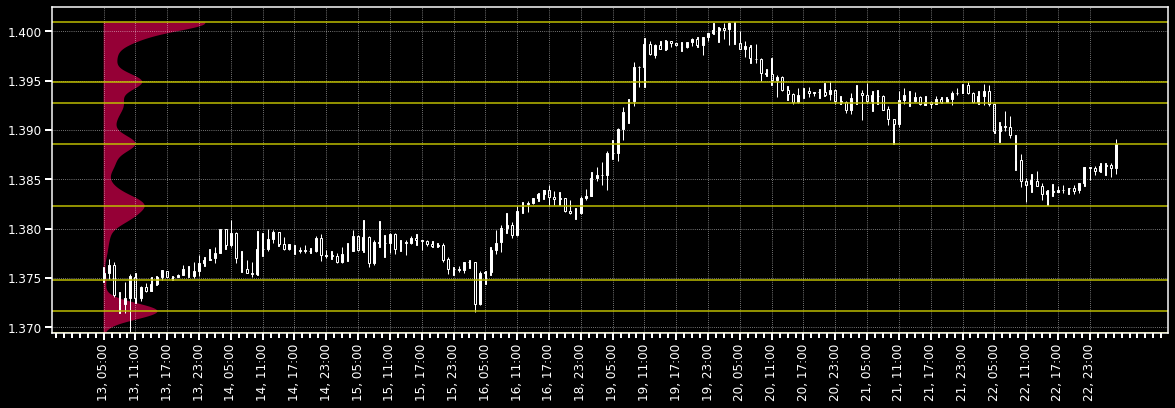

In [ ]:
Mesh.sort()
_f5, _a5 = GMAPlot.candle_plot(Data1)
res, X, Y = clustering1D.gKernel(Mesh)
res = numpy.hstack((Mesh[0], res, Mesh[-1]))
for line in res: _a5.axhline(y = line, color = "y")
Y = (Y/Y.max())*(len(Data1)/10)
_a5.fill_betweenx(y = X, x1 = Y, x2 = 0*Y, alpha = 4/5);

In [ ]:
res

array([1.36944   , 1.37163157, 1.37477688, 1.38229518, 1.38860609,
       1.39270852, 1.39485951, 1.40091   ])

### <center><b><u>Estrategia predictiva</u></b></center>

Ya teniendo las dos herramientas fundamentales para anticipar la contratendencia, pasaremos a formular la forma en la cual decidimos como y cuando considerar una posible señal de entrada. Para este instante, tengo que tener ya una lista completa de lineas de reversión ("``REV``") y de soporte & resistencia ("``SNR``"). Como en todo momento necesitamos saber cuales son las lineas mas cercanas al precio actual, lo ideal es que  estas listas estén ya ordenadas de menor a mayor. También deben irse actualizando periodicamente al paso del tiempo.

Así como en una prueba en [ForexTester](https://drive.google.com/file/d/1nj1NFePCOoH9K3wKgz35bsOMLpX9IqtW), necesito tener datos de mercado previos a la jornada operativa, para hacer mis análisis y recolectar las líneas "``REV``" y "``SNR``". La cantidad de días que voy a contemplar, depende de la preferencia personal. Hay que tener en cuenta que **Finnhub.io** tiene el límite de 120 días ("``days``") de descarga en H1: si elijo analizar 90 ("``scan``"), solo voy a poder backtestear 30 ("``days - scan``"). Pasa algo similar al "[train-test-split](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)" de machine learning, solo que al revés: el (back)testing debe quedarse con la porción significativamente mas grande de la torta. 

**Recordar** que como los fines de semana no hay datos de mercado, siempre voy a obtener menos datos de los que especifico.<br>(Por ejemplo: si quiero 20 días de datos, voy a obtener 14, ya que en el medio pasé por 3 sabados y 3 domingos).

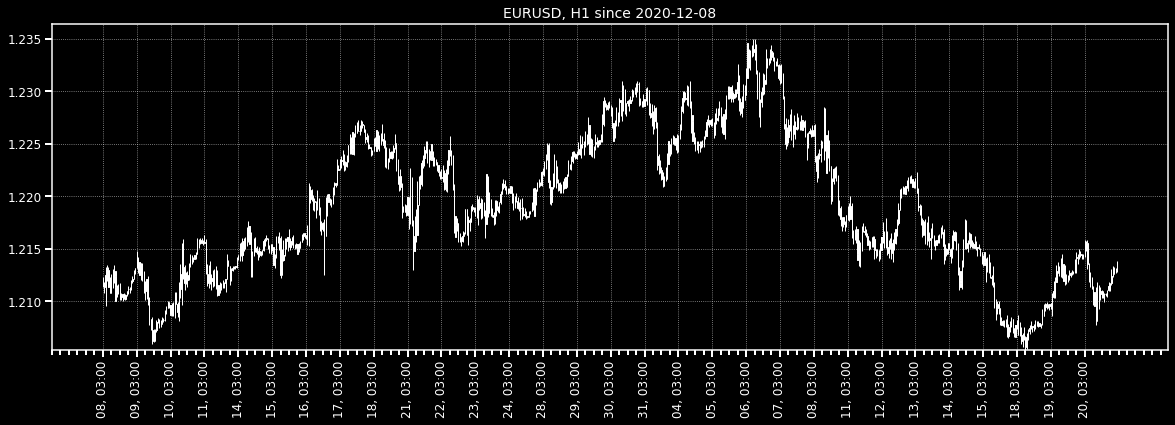

In [ ]:
days, split = 120, 30
symbol, frame = "EURUSD", 3600
rows = int(86400/frame)*days
split = int(86400/frame)*split
Data2 = download_iq(symbol, frame, rows)
day1 = Data2.index[0].date()
Scan = Data2.index[: split]
Test = Data2.index[split :]
tf = GMAData.tfconv(frame)
title = f"{symbol}, {tf} since {day1}"
_f6, _a6 = GMAPlot.candle_plot(Data2.loc[Scan, :])
_a6.set_title(title, fontsize = 14);

In [ ]:
class Strategy:
    def __init__(self, revArgs: dict = dict(), snrArgs: dict = dict(),
                 ctime: datetime.time = datetime.time(hour = 4)):
        mstep = revArgs["mstep"] if ("mstep" in revArgs) else 1e-4
        msize = revArgs["msize"] if ("msize" in revArgs) else 48
        self.__REV = LineStack(mstep = mstep, msize = msize)
        mstep = snrArgs["mstep"] if ("mstep" in snrArgs) else 5e-4
        msize = snrArgs["msize"] if ("msize" in snrArgs) else 24
        self.__SNR = LineStack(mstep = mstep, msize = msize)
        self.__ctime = ctime
    def get_ctime(self): return self.__ctime
    def set_ctime(self, ctime: datetime.time = \
        datetime.time(hour = 4)): self.__ctime = ctime
    def values(self):
        return {"REV": self.__REV.values(),
                "SNR": self.__SNR.values()}
    def reset(self, which: str = None):
        if (which == None) or (which.upper() == "REV"):
            self.__REV = LineStack(**self.__REV.limits())
        if (which == None) or (which.upper() == "SNR"):
            self.__SNR = LineStack(**self.__SNR.limits())
    def __repr__(self):
        print("Info about 4AM Strategy:")
        info = REV.limits(), SNR.limits()
        display(pandas.DataFrame(info, index = ["REV", "SNR"]))
        print(f"\nCore time: {self.__ctime.strftime('%H:%M')}")
        return ""

In [ ]:
class Strategy(Strategy):
    def __init__(self, revArgs: dict = dict(), snrArgs: dict = dict(),
                 ctime: datetime.time = datetime.time(hour = 4)):
        super().__init__(revArgs, snrArgs, ctime)
    def __scan_ctime(self, data: pandas.DataFrame, width: int, frame = int):
        d_t = datetime.timedelta(seconds = frame)
        h, m = self.__ctime.hour, self.__ctime.minute
        c_time = dT(*(1970, 1, 1), hour = h, minute = m)
        L_time = (c_time - (width//2)*d_t).time()
        R_time = (c_time + (width//2)*d_t).time()
        index = (L_time <= data.index.time)
        index &= (data.index.time <= R_time)
        return data.index[index]

In [ ]:
class Strategy(Strategy):
    def __init__(self, revArgs: dict = dict(), snrArgs: dict = dict(),
                 ctime: datetime.time = datetime.time(hour = 4)):
        super().__init__(revArgs, snrArgs, ctime)
    def __scan_rev(self, block, width, k_min, smode, exact):
            scan = LineStack.RevScan(block, k_min = k_min)
            if not scan: return
            if not exact:
                if (scan["curv"] < 0): scan["value"] = block.iloc[width//2, 1]
                if (scan["curv"] > 0): scan["value"] = block.iloc[width//2, 2]
            if exact and (scan["dtime"].time() != self.__ctime): return
            scan["dtime"] = dT.combine(scan["dtime"].date(), self.__ctime)
            if (smode == "div"):
                scan["score"] = abs(scan["curv"])/k_min
                scan["score"] = scan["score"].round(3) - 1
            scan.pop("curv") ; self.__REV.append(**scan)

In [ ]:
class Strategy(Strategy):
    def __init__(self, revArgs: dict = dict(), snrArgs: dict = dict(),
                 ctime: datetime.time = datetime.time(hour = 4)):
        super().__init__(revArgs, snrArgs, ctime)
    def scan_rev(self, data: pandas.DataFrame, revArgs: dict = dict()):
            width = revArgs["width"] if ("width" in revArgs) else 5
            k_min = revArgs["k_min"] if ("k_min" in revArgs) else 2e-4
            smode = revArgs["smode"] if ("smode" in revArgs) else "div"
            exact = revArgs["exact"] if ("exact" in revArgs) else True
            revArgs = {"width": width, "k_min": k_min,
                       "exact": exact, "smode": smode}
            start = data.index[0].date() + datetime.timedelta(days = 1)
            data = data[start <= data.index.date]
            frame = (data.index[1] - data.index[0]).seconds
            r_index = self.__scan_ctime(data, width, frame)
            width = 2*(width//2) + 1
            for day in range(len(r_index)//width):
                L_time = r_index[width*(day + 0) - 0]
                R_time = r_index[width*(day + 1) - 1]
                block = data.loc[L_time : R_time, :]
                self.__scan_rev(block, **revArgs)

In [ ]:
class Strategy(Strategy):
    def __init__(self, revArgs: dict = dict(), snrArgs: dict = dict(),
                 ctime: datetime.time = datetime.time(hour = 4)):
        super().__init__(revArgs, snrArgs, ctime)
    def scan_snr(self, data: pandas.DataFrame, snrArgs: dict = dict()):
            p_range = snrArgs["p_range"] if ("p_range" in snrArgs) else range(2, 200, 2)
            pct_min = snrArgs["pct_min"] if ("pct_min" in snrArgs) else 0.0
            scr_min = snrArgs["scr_min"] if ("scr_min" in snrArgs) else 0.05
            Mesh = LineStack.meshtest(data, p_range)
            mstep = self.__SNR.limits()["step"]
            Mesh = numpy.floor(Mesh/mstep)*mstep
            # Count = pandas.value_counts(Mesh)
            # c_min = Count.iloc[0]*pct_min
            # Count = Count[Count > c_min]
            scans, X, Y = clustering1D.gKernel(Mesh)
            dtime, y_max = data.index[0], Y.max()
            for value in scans:
                index = (X < value).sum()
                score = Y[index - 1]/y_max
                if (score < scr_min): continue
                self.__SNR.append(value, dtime, score)

In [ ]:
S = Strategy()
S.scan_snr(Data2.iloc[: split, :])

In [ ]:
width = 3 ## Impar, mayor o igual a 3
k_min = 1/10000
c_time = dT(*(1970, 1, 1), hour = 4)
REV = LineStack(mstep = 5e-4, msize = 48)
d_t = datetime.timedelta(seconds = frame)
L_time = (c_time - (width//2)*d_t).time()
R_time = (c_time + (width//2)*d_t).time()
c_time = c_time.time()
blocks = (L_time <= Scan.time)
blocks &= (Scan.time <= R_time)
blocks = Data2.loc[Scan, :].loc[blocks, :]
for i in range(0, len(Scan), 86400//frame):
    
#    t = Scan[24*i]
#    print(t)
    #print("Date in 'Data2':", Data2.index[24*i +])
    #block = blocks.iloc[i : i + width, :]
    #scan = LineStack.RevScan(block, k_min)
    #if not scan: continue
    #scan["score"] = abs(scan["curv"])/k_min
    #scan["score"] = scan["score"].round(3) - 1
    #scan["index"] += 24*i ;  scan.pop("curv")
    #REV.append(**scan)

0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696


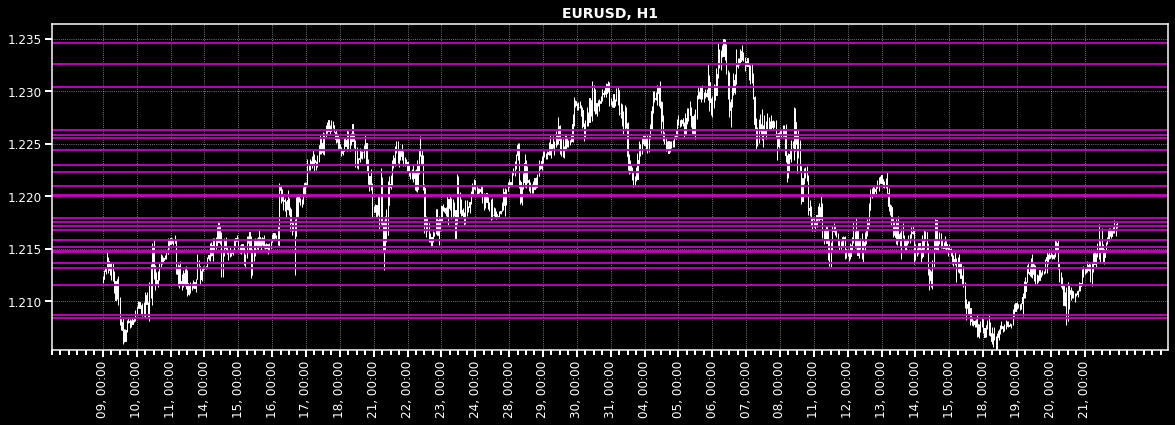

In [ ]:
for line in REV.values().index:
    _a6.axhline(y = line, xmin = 0, color = "m")
_f6

In [ ]:
Scan, Test = Data.index[:split], Data.index[split:]
#SNR = SnrArray(min_pcc = 1e-3, max_len = 50)
#SNR.scan(OHLC = Data.loc[Scan, :], q_min = 1/10)
blocks = (tL <= Scan.time) & (tR >= Scan.time)
REV = RevArray(min_pcc = 1e-5, max_len = 15)
Data2 = Data.reset_index()
REV.scan(OHLC = Data2.loc[Scan[blocks], :], width = width, k_min = 0)
print(f"Reversals: {REV}")  ;  print(f"S&R lines: {SNR}")
print(f"Fecha de comienzo: {Test[0]}")

In [ ]:
REV.

In [ ]:
Figure5, Axes5 = GMAPlot.candle_plot(Data.loc[Scan, :]) ## Gráfica de velas.
Axes5.set_title("Gráfica completa", fontsize = 14, fontweight = "bold")
for x in numpy.where(Scan.time == tC)[0]:
    Axes5.axvline(x, lw = 10, alpha = 1/5)
for i in range(len(REV.values())):
    x, y = REV.dtimes()[i], REV.values()[i]
    Axes5.axhline(xmin = x, y = y, color = "violet", ls = "--", alpha = 4/5)
# for y in SNR.values(): Axes5.axhline(y, color = "orange", ls = "--", alpha = 3/5)
Axes5.grid(False)
Figure5.set_figwidth(70)
Figure5.set_figheight(10)
Figure5.savefig("B:\\Otros\\Desktop\\NZDUSD 210115 REV.jpg")

#### <b><u>Condiciones de ejecución</u></b>

Esta primera parte depende mas que nada de la presencia de una linea de reversión cercana. En la forma mas simple:
* El precio **subirá** ("``sign = +1``") si la vela que se encuentra formandose, toca una línea de reversión **desde arriba hacia abajo**.
* El precio **bajará** ("``sign = -1``") si la vela que se encuentra formandose, toca una línea de reversión **desde abajo hacia arriba**.

In [ ]:
Data[["REV(-)", "REV(+)", "Signal"]] = 0, numpy.inf, 0
times = enumerate(Data.index[split :], start = split)
t_exec = datetime.time(hour = 4, minute = 0)
t_scan = datetime.time(hour = 0, minute = 0)
for i, time in times:
    if (time.time() == t_scan):
        i0 = i - split
        recent = Data.iloc[i0 : i + 1]
        SNR.scan(recent, q_min = 0.1)
        recent = recent.iloc[-25 :]
        mid = (recent.index.time == t_exec)
        mid = numpy.where(center)[0][0]
        i1 = mid - width//2
        i2 = mid + width//2 + 1
        REV.scan(recent.iloc[i1 : i2, :])
    if (time.time() == t_exec):
        o, h, l = Data.loc[time, list("OHL")]
        rev_b, rev_a = REV.bind(o)
        sign = 1*(h >= rev_a) - 1*(l <= rev_b)
        Data.loc[time, "REV(-)"] = rev_a
        Data.loc[time, "REV(+)"] = rev_b
        Data.loc[time, "Signal"] = sign

#### <b><u>Condiciones de validación</u></b>